# Recurrent Neural Networks

- this chapter deals with variable length sequence data
- fundamentally different from previous modalities
- text, time series prediction, video analysis, and musical information retrieval
- we will focus on text data which is our primary interest
- tasks such as translating passages of text from one natural language to another, 
- engaging in dialogue, or controlling a robot, demand that models both ingest and output sequentially structured data.

- we will focus primarily on recurrent neural networks (RNNs) and its variants
- RNNs are deep learning models that capture the dynamics of sequences via recurrent connections, 
- which can be thought of as cycles in the network of nodes. 
- recurrent neural networks allow iterative updates to a hidden state vector
- the updates depend on the precise order that inputs are pushed into the network

- we describe the method for calculating gradients when backpropagating through RNNs and explore some challenges that are often encountered when training such networks, motivating the modern RNN architectures that will follow in the next chapter



- Recurrent neural networks are unrolled across time steps (or sequence steps), 
- such that RNNs can be thought of as feedforward neural networks where each layer’s parameters (both conventional and recurrent) are shared across time steps.
- While the inputs and targets for many fundamental tasks in machine learning cannot easily be represented as fixed-length vectors, they can often nevertheless be represented as varying-length sequences of fixed-length vectors. For example, documents can be represented as sequences of words; medical records can often be represented as sequences of events (encounters, medications, procedures, lab tests, diagnoses); videos can be represented as varying-length sequences of still images.


## Sequence data

- $\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T$ where $\boldsymbol{\mathsf{x}}_i \in \mathbb{R}^d$ for $i = 1, \ldots, T.$
- e.g. collection of words in a document, sequence of events that occur for an RL agent
- in each of these, the entities are represented using a state vector in $\mathbb{R}^d$


- sometimes fixed target $\boldsymbol{\mathsf{y}}$ (e.g. sentiment) for entire series
- or $\boldsymbol{\mathsf{y}}_1, \ldots, \boldsymbol{\mathsf{y}}_T$ at each point in the series given a fixed input $\boldsymbol{\mathsf{x}}$ (e.g. image captioning)
- $\boldsymbol{\mathsf{y}}_1, \ldots, \boldsymbol{\mathsf{y}}_T$ with $\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T$ (e.g., machine translation or video captioning)
- Such sequence-to-sequence tasks take two forms: (i) aligned: where the input at each time step aligns with a corresponding target (e.g., part of speech tagging); (ii) unaligned: where the input and target do not necessarily exhibit a step-for-step correspondence (e.g., machine translation).

## Autoregressive modeling

- $p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1})$
- entire distribution hard to compute, and a user can be content with $\mathbb{E}\left[\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}\right]$ e.g. with a linear regression model
- such models that regress the value of a signal on the previous values of that same signal are naturally called autoregressive models.
- one issue is that the inputs vary with $t$. 
- In other words, the number of inputs increases with the amount of data that we encounter.
- Much of what follows in this chapter revolve around techniques for dealing with this when estimating $p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1})$
 or some statistic(s) of this distribution.



- first strategy is to only use past $\tau$ observations, so that we estimate $p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t-\tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1})$
- then all inputs are of length $\tau$
- this allows us to train any linear model or deep network that requires fixed-length vectors as inputs.
-  Second, we might develop models that maintain some summary $\boldsymbol{\mathsf{h}}_t$ of the past observations used to predict the next output and also updates with each observation, i.e. $\boldsymbol{\mathsf{y}}_t = f(\boldsymbol{\mathsf{h}}_{t})$ and $\boldsymbol{\mathsf{h}}_t = g(\boldsymbol{\mathsf{x}}_{t-1}, \boldsymbol{\mathsf{h}}_{t-1}).$
- Since $\boldsymbol{\mathsf{h}}_t$ is never observed, these models are also called **latent autoregressive models**.


<br>

- To construct training data from historical data, one typically creates examples by sampling windows randomly
- we often assume that the underlying data generation process does not change, i.e. is stationary. In practice, this
means that the weights are independent of the current time step.

## Sequence models

- when working with language we want to estimate the joint probability of an entire sequence
- common task when working with sequences composed of discrete tokens is to estimate probabilities of sequences. 
- Language models prove useful for all sorts of reasons. 
- Sometimes we want to evaluate the likelihood of sentences. For example, we might wish to compare the naturalness of two candidate outputs generated by a machine translation system or by a speech recognition system. 
- But language modeling gives us not only the capacity to evaluate likelihood, but the ability to generate sequences, and even to optimize for the most likely sequences.
- Recall that we can write a joint distribution as a chain of conditional distributions:
$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_T) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 2}^{T} p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1}).
$$
- for discrete signals the output of a model must be a probability distribution $p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1})$. 
- Markov condition: the future is conditionally independent of the past, given the recent history
- We often find it useful to work with models that proceed as though a Markov condition were satisfied, even when we know that this is only approximately true. With real text documents we continue to gain information as we include more and more leftwards context. But these gains diminish rapidly. Thus, sometimes we compromise, obviating computational and statistical difficulties by training models whose validity depends on a 
kth-order Markov condition.

In [1]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

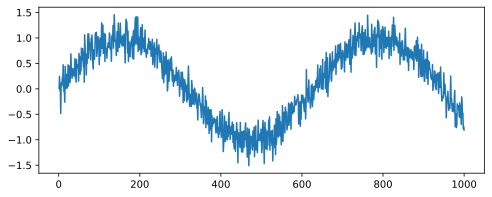

In [2]:
import torch

batch_size=16
T=1000
num_train=600
tau=4
t = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * t) + torch.randn(T) * 0.2
plt.figure(figsize=(8, 3))
plt.plot(t, x);

Our task is to model $[\boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t - 1}] \mapsto \boldsymbol{\mathsf{x}}_{t}$

In [3]:
# stack offsets each with length T - tau
f = torch.stack([x[i: T-tau+i] for i in range(tau)], 1)
print(f.shape)
f

torch.Size([996, 4])


tensor([[ 0.0089,  0.2459, -0.0331,  0.0454],
        [ 0.2459, -0.0331,  0.0454, -0.4839],
        [-0.0331,  0.0454, -0.4839,  0.0934],
        ...,
        [-0.1593, -0.2613, -0.5211, -0.4757],
        [-0.2613, -0.5211, -0.4757, -0.7842],
        [-0.5211, -0.4757, -0.7842, -0.7387]])

In [4]:
y = x[tau: ].reshape(-1, 1)
y[0]

tensor([-0.4839])

Creating the data loader:

In [5]:
from torch.utils.data import TensorDataset, DataLoader

data = TensorDataset(f, y)
input, tgt = next(iter(data))
input, tgt

(tensor([ 0.0089,  0.2459, -0.0331,  0.0454]), tensor([-0.4839]))

In [6]:
import torch.nn as nn

model = nn.Sequential(nn.Linear(4, 1))
optim = torch.optim.SGD(model.parameters(), lr=0.01)
for e in range(3):
    for input, tgt in DataLoader(data, batch_size=16, shuffle=True):
        loss = ((model(input) - tgt) ** 2).mean()
        loss.backward()
        optim.step()
        optim.zero_grad()

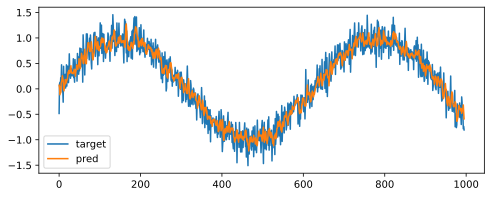

In [9]:
plt.figure(figsize=(8, 3))
plt.plot(y, label="target")
plt.plot(model(f).reshape(-1).tolist(), label="pred")
plt.legend();

look ahead predictions. suppose we have measurement data up to $t = 604$ and we want to predict $t = 605, \ldots, 609$. To do this we can reuse predictions. Beginning precisely $t = 609$, we use solely predicted values instead of observed data:

$$
\begin{aligned}
& \hat{x}_{605}=f\left(x_{601}, x_{602}, x_{603}, x_{604}\right) \\
& \hat{x}_{606}=f\left(x_{602}, x_{603}, x_{604}, \hat{x}_{605}\right) \\
& \hat{x}_{607}=f\left(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}\right) \\
& \hat{x}_{608}=f\left(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}\right) \\
& \hat{x}_{609}=f\left(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}\right)
\end{aligned}
$$

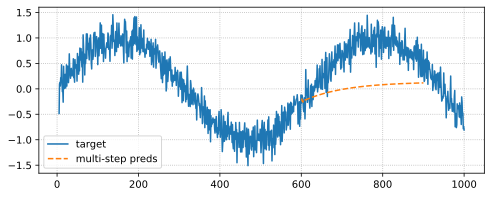

In [11]:
t0 = 601
preds = []
k_max = 300
ctx = x[t0: t0 + tau].tolist()
for i in range(k_max):
    x_hat = model(torch.tensor(ctx).reshape(1, -1))[0]
    preds.append(x_hat.item())
    ctx = ctx[1:] + [x_hat]


plt.figure(figsize=(8, 3))
plt.plot(t[tau:], y, label="target")
plt.plot(range(t0, t0 + k_max), preds, label="multi-step preds", linestyle="dashed")
plt.grid(linestyle="dotted")
plt.legend();

## Raw test to sequence data

In [12]:
import collections
import random
import re
import torch

we will work with H. G. Wells’ [The Time Machine](http://www.gutenberg.org/ebooks/35), a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline. 

In [135]:
!rm chapter.py; touch chapter.py

In [136]:
!mkdir ./data
!curl "https://www.gutenberg.org/cache/epub/35/pg35.txt" --output ./data/time_machine.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199k  100  199k    0     0   110k      0  0:00:01  0:00:01 --:--:--  110k


This has some prefix by Project Gutenberg that we have to remove:

In [148]:
text = open("./data/time_machine.txt").read()
text[:300]

'\ufeffThe Project Gutenberg eBook of The Time Machine\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License'

In [149]:
start = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
end = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
text = text[text.find(start) + len(start): text.find(end)]
text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
print(text[:100])
print(text[-100:])

the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man


### Tokenization

Tokens are the atomic units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. For example, we could represent the sentence “Baby needs a new pair of shoes” as a sequence of 7 words, where the set of all words comprise a large vocabulary (typically tens or hundreds of thousands of words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). Below, we tokenize our preprocessed text into a sequence of characters.



In [150]:
tokens = list(text)
", ".join(tokens[:42])  # https://en.wikipedia.org/wiki/File:Answer_to_Life_42.svg

't, h, e,  , t, i, m, e,  , m, a, c, h, i, n, e,  , a, n,  , i, n, v, e, n, t, i, o, n,  , b, y,  , h,  , g,  , w, e, l, l, s'

### Vocabulary

can think of vocab as dictionary that maps `token` $\mapsto$ `index`
and also offers utils such as an inversion map

In [107]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itot = ["<unk>"] + list(sorted(set(
            reserved_tokens +   # i.e. reserved = not subject to min_freq
            [token for token, freq in self.token_freqs if freq >= min_freq]
        )))
        self.ttoi = {tok: idx for idx, tok in enumerate(self.itot)}

    def __len__(self):
        return len(self.itot)
    
    def __getitem__(self, tokens):
        if isinstance(tokens, (list, tuple)):
            return [self.__getitem__(tok) for tok in tokens]
        else:
            return self.ttoi.get(tokens, self.unk)
            
    def to_tokens(self, indices):
        if hasattr(indices, "__len__"):
            return [self.itot[int(index)] for index in indices]
        else:
            return self.itot[indices]

    @property
    def unk(self) -> int:
        return self.ttoi["<unk>"]

Recall that `tokens` is `list(text)`.

In [378]:
vocab = Vocab(tokens=tokens) 
corpus = vocab[tokens]

assert len(set(corpus)) + 1 == len(vocab)
print(len(vocab))
print(vocab.token_freqs[:3], "...", vocab.token_freqs[-3:])
print(len(corpus))
print(vocab.to_tokens(corpus[:16]))

28
[(' ', 32894), ('e', 17918), ('t', 13591)] ... [('z', 106), ('j', 97), ('q', 95)]
174215
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e']


In [234]:
import os
import requests

class TimeMachine:
    def __init__(self, download=False):
        self.filepath = "./data/time_machine.txt"
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _preprocess(self, text: str):
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    def _tokenize(self, text: str):
        return list(text)

    def build(self, vocab=None):
        with open(self.filepath, "r") as f:
            text = f.read()
        
        text = self._preprocess(text)
        self.text = text
        self.tokens = self._tokenize(text)
        if vocab is None: 
            vocab = Vocab(self.tokens)

        corpus = vocab[tokens]
        return corpus, vocab

In [235]:
tm = TimeMachine(download=True)
corpus, vocab = tm.build()

In [236]:
print(tm.text[:100])
print(tm.text[-100:])
len(corpus), len(vocab)

the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man


(174215, 28)

In [237]:
tm.text

'the time machine an invention by h g wells contents i introduction ii the machine iii the time traveller returns iv time travelling v in the golden age vi the sunset of mankind vii a sudden shock viii explanation ix the morlocks x when night came xi the palace of green porcelain xii in the darkness xiii the trap of the white sphinx xiv the further vision xv the time traveller s return xvi after the story epilogue i introduction the time traveller for so it will be convenient to speak of him was expounding a recondite matter to us his pale grey eyes shone and twinkled and his usually pale face was flushed and animated the fire burnt brightly and the soft radiance of the incandescent lights in the lilies of silver caught the bubbles that flashed and passed in our glasses our chairs being his patents embraced and caressed us rather than submitted to be sat upon and there was that luxurious after dinner atmosphere when thought runs gracefully free of the trammels of precision and he put i

Trying out the `<unk>` token for unknown characters:

In [248]:
vocab.to_tokens(vocab[list("$w@gger")])

['<unk>', 'w', '<unk>', 'g', 'g', 'e', 'r']

## Appendix: Zipf's law

After a few words that are considered exceptions, the frequency $f_i$ of the $i$-th most frequent word decays as follows:

$f_i \propto i^{-\alpha}$

which is equivalent to

$\log f_i = -\alpha \log i + c$

where $\alpha$ characterizes the token distribution and $c$ is a constant for the proportionality.

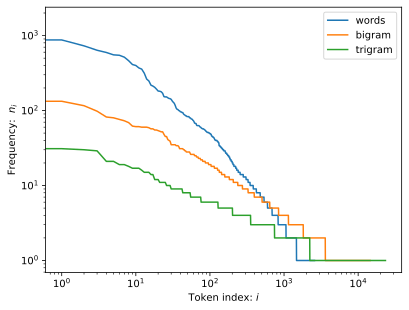

In [265]:
words = text.split()
word_freqs = Vocab(words).token_freqs
bigram_freqs = Vocab(["__".join(pair) for pair in zip(words[:-1], words[1:])]).token_freqs
trigram_freqs = Vocab(["__".join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]).token_freqs

plt.plot([freq for _, freq in word_freqs], label="words")
plt.plot([freq for _, freq in bigram_freqs], label="bigram")
plt.plot([freq for _, freq in trigram_freqs], label="trigram")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Frequency:  $n_i$")
plt.xlabel("Token index: $i$")
plt.legend();

**Remark.** Similar behavior (indeed a similar $\alpha$) has been observed for other English stories (e.g. [*Alice's Adventures in Wonderland*](https://www.gutenberg.org/cache/epub/11/pg11.txt)).

## Language models

Assume that a piece of text $s$ has been converted to a sequence of tokens $\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T.$  The goal of language models is to estimate the joint probability of the whole sequence:

$$
p(\boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_T).
$$

Language models are incredibly useful. For instance, an ideal language model should generate natural text on its own, simply by drawing one token at a time $\boldsymbol{\mathsf{x}}_t \sim p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1})$.

- instead of gibberish, it would be sufficient for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments
- we are still very far from designing such a system, since it would need to *understand* the text rather than just generate grammatically sensible content (e.g. in terms of likelihood).
- Nonetheless, language models are of great service even in their limited form. 
- For instance, the phrases “to recognize speech” and “to wreck a nice beach” sound very similar. This can cause ambiguity in speech recognition, which is easily resolved through a language model that rejects the second translation as outlandish (i.e. low probability of occuring).

$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_T) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 2}^{T} p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1}).
$$

$$
\begin{aligned}
&p(\text{deep}, \text{learning}, \text{is}, \text{fun}) \\
= &p(\text{deep}) \cdot p(\text{learning} \mid \text{deep}) \cdot p(\text{is} \mid \text{deep}, \text{learning}) \cdot p(\text{fun} \mid \text{deep}, \text{learning}, \text{is}).
\end{aligned}
$$

- **Remark.** The probabilities can be estimated by [relative frequencies](https://en.wikipedia.org/wiki/Empirical_probability) perhaps with [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing), e.g. $p(\text{deep} \mid \text{learning}) \approx n(\text{deep}, \text{learning}) / n(\text{learning})$ . Moreover, we can truncate the context to at most $\tau$ many terms as a Markov hypothesis.

## Perplexity

- how to measure the quality of the language model, which we will then use to evaluate our models in the subsequent sections. 
- One way is to check how *surprising* the text is.
- A good language model is able to predict, with high accuracy, the tokens that come next.
- Consider the following continuations of the phrase "It is raining", as proposed by different language models:
    ```
    “It is raining outside”
    “It is raining banana tree”
    “It is raining piouw;kcj pwepoiut”
    ```

- Example 1 is clearly the best, although not necessarily factual or accurate, model predicts kind of word correctly.
- example 2 is nonsensical, but at least model has learned some degree of correlation between words (banan & tree)
- example 3 indicates poor training

To evaluate a language model, we can use the cross-entropy on the next token which is equivalent to maximizing the likelihood of a text. We normalize this over the number of tokens predicted:

$$
\mathcal{L} = \frac{1}{n}\sum_{t=1}^n - \log p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1})
$$

Here we condition on a fixed number of tokens $\tau$ which means we sample a fixed number of tokens at each step (e.g. a moving window). For a classifier that predicts all tokens uniformly random, then $\mathcal{L} = \log |\mathcal{V}|$ where $\mathcal{V}$ is the set of tokens. This is a useful baseline. A similarly simple model predicts based on prior probabilities for each token based on count in the training data.

Historically, researchers in NLP also use *perplexity* (PP) which is simply the exponential of the above expression:

$$
\exp\left(\frac{1}{n}\sum_{t=1}^n - \log p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1})\right).
$$

Note that perplexity is equivalent to an inverse likelihood: 

$$
\text{PP} = \frac{1}{\sqrt[n]{\prod_{t=1}^n p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1})}}.
$$

Hence, for a perfect model, $\text{PP} = 1.$ On the other hand, if the model predicts $p \approx 0$ for the correct token at each step, then we get $\text{PP} = \infty.$ As a baseline, for a uniformly random model, we have $\text{PP} = |\mathcal{V}|.$ This provides a nontrivial upper bound that any useful model must beat. So, we have $\text{PP}$ values $\infty > |\mathcal{V}| \geq 1$ for the three regimes. 

**Remark.** For the usual cross entropy, this corresponds to $\infty > \log |\mathcal{V}| \geq 0.$

## Recurrent Neural Networks (RNN)

In the previous chapter we described a Markov model using $n$-grams where the conditional probability of token $\boldsymbol{\mathsf{x}}_t$ depends only on the last $n-1$ tokens. If we want to incorporate the possible effect of tokens earlier than $n-1$ time steps, we need to increase $n$. But as we saw the number of model parameters would also increase exponentially with it as we need to store $|\mathcal{V}|^n$ numbers for a vocabulary set $\mathcal{V}.$ Furthermore, by Zipf's law, data becomes more sparse as $n$ increases, so the model does not necessarily improve with larger $n.$

Rather than modeling the next token directly in terms of previous tokens, we can instead use a latent variable that, in principle, stores *all* previous information up to the previous time step:

$$
p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t-1}) \approx p(\boldsymbol{\mathsf x}_{t} \mid \boldsymbol{\mathsf h}_{t-1})
$$

where $\boldsymbol{\mathsf h}_{t-1}$ is a *hidden state* that stores information up to the time step $t - 1.$ The hidden state is updated based on the current input and the previous state: 

$$
\boldsymbol{\mathsf h}_{t} = f(\boldsymbol{\mathsf x}_{t}, \boldsymbol{\mathsf h}_{t-1}),
$$

so that $\boldsymbol{\mathsf h}_{t} = F(\boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t}, \boldsymbol{\mathsf h}_{0})$ for some $\boldsymbol{\mathsf h}_{0}$ where $F$ involves recursively applying $f.$ Note that for a sufficiently powerful function $f$, the latent variable model above is not an approximation, since $\boldsymbol{\mathsf h}_{t}$ can simply store all $\boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t}$ it has observed so far. 

### Simple RNN

RNNs use the same parameters at each time step, i.e. it is assumed that the dynamics is stationary. Practically, this means that the number of parameters does not grow as the sequence length increases.
The following implementation is called **Simple RNN**, the state update is calculated using essentially a linear layer where the embedding and hidden state are concatenated as input. Let tokens correspond to embedding vectors $\boldsymbol{\mathsf{x}}_t \in \mathbb{R}^d$, then

$$
\begin{aligned}
\boldsymbol{\mathsf{h}}_t &= \varphi(\boldsymbol{\mathsf{x}}_t \boldsymbol{\mathsf{U}} + \boldsymbol{\mathsf{h}}_{t-1} \boldsymbol{\mathsf{W}} + \boldsymbol{\mathsf{b}}) \\
\boldsymbol{\mathsf{y}}_t &= \boldsymbol{\mathsf{h}}_t \boldsymbol{\mathsf{V}} + \boldsymbol{\mathsf{c}}
\end{aligned}
$$

where $\boldsymbol{\mathsf{U}} \in \mathbb{R}^{d \times h}$, $\boldsymbol{\mathsf{W}} \in \mathbb{R}^{h \times h}$, and $\boldsymbol{\mathsf{b}} \in \mathbb{R}^{h}.$ Here $h$ is the dimensionality of the hidden state. For the outputs, we also have $\boldsymbol{\mathsf{V}} \in \mathbb{R}^{h \times q}$ and $\boldsymbol{\mathsf{c}} \in \mathbb{R}^{q}$ where $q$ is the dimensionality of the output. This computation can be seen in {numref}`04-simple-rnn`.

<br>

```{figure} ../../../img/nn/04-simple-rnn.svg
---
width: 600px
name: 04-simple-rnn
align: center
---
Computational graph of an unrolled simple RNN. [Source](https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html)
```

First, we implement the recurrent layer. To implement batch computation, an input has shape $(B, T, d).$ That is, a batch of $B$ sequences of length $T$, consisting of vectors in $\mathbb{R}^d.$ Elements of a batch are computed in independently, ideally in parallel. At each step, the layer returns the state vector of shape $(B, h).$ This is stacked to get a tensor of shape $(B, T, h)$ consistent with the input.

In [348]:
import numpy as np
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, dim_inputs, dim_hidden):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.dim_inputs = dim_inputs
        self.W = nn.Parameter(torch.randn(dim_hidden, dim_hidden) / np.sqrt(dim_hidden))
        self.U = nn.Parameter(torch.randn(dim_inputs, dim_hidden) / np.sqrt(dim_inputs))
        self.b = nn.Parameter(torch.zeros(dim_hidden))

    def forward(self, x, state=None):
        x = x.transpose(0, 1)   # (B, T, d) -> (T, B, d)
        T, B, d = x.shape
        assert d == self.dim_inputs
        if state is None:
            state = torch.zeros(B, self.dim_hidden)
        else:
            assert state.shape == (B, self.dim_hidden)
        
        outs = []
        for t in range(T):
            state = torch.tanh(x[t] @ self.U + state @ self.W + self.b)
            outs.append(state)
        
        outs = torch.stack(outs)
        outs = outs.transpose(0, 1)
        return outs, state

Shapes test:

In [366]:
h = 5
B, T, d = 32, 10, 512
rnn = SimpleRNN(dim_inputs=d, dim_hidden=h)
outs, state = rnn(torch.randn(B, T, d))
assert outs.shape == (B, T, h)
assert state.shape == (B, h)
assert torch.abs(outs[:, -1, :] - state).max() < 1e-8

In [372]:
tm = TimeMachine()
corpus, vocab = tm.build()

In [375]:
len(corpus), len(vocab)

(174215, 28)

<br>

```{figure} ../../../img/nn/04-char-rnn.svg
---
width: 550px
name: 04-char-rnn
align: center
---
Character-level RNN language model for predicting the next character at each step.  [Source](https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html)
```

Our goal in the following language model is to predict the next token. 
Hence, we only need the final state.

In [457]:
class RNNLanguageModel(nn.Module):
    """RNN based language model."""
    def __init__(self, dim_inputs, dim_hidden, vocab_size):
        super().__init__()
        self.rnn = SimpleRNN(dim_inputs=dim_inputs, dim_hidden=dim_hidden)
        self.out_layer = nn.Linear(dim_hidden, vocab_size)

    def forward(self, x, state=None):
        _, state = self.rnn(x, state)
        return self.out_layer(state), state


In [458]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, corpus: list, seq_len: int, vocab_size: int):
        super().__init__()
        self.corpus = corpus
        self.seq_len = seq_len
        self.vocab_size = vocab_size

    def __getitem__(self, i):
        assert i + self.seq_len <= len(self.corpus)
        x = torch.tensor(self.corpus[i: i + self.seq_len])
        x = F.one_hot(x, num_classes=self.vocab_size).float()
        return x[:-1], x[-1]
    
    def __len__(self):
        return len(self.corpus) - self.seq_len + 1

In [444]:
dataset = SequenceDataset(corpus, 10, vocab_size=len(vocab))
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)

In [445]:
inp, tgt = dataset[0]
inp.shape, tgt.shape

(torch.Size([9, 28]), torch.Size([28]))

In [446]:
x, y = next(iter(dataloader))

In [447]:
x.shape, y.shape

(torch.Size([32, 9, 28]), torch.Size([32, 28]))

In [460]:
import torch.nn.functional as F

model = RNNLanguageModel(28, 5, len(vocab))
loss = F.cross_entropy(model(x)[0], y)  # model(x) -> (out, state)
loss

tensor(3.3359, grad_fn=<DivBackward1>)

In [461]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

model = RNNLanguageModel(len(vocab), 32, len(vocab))
optim = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3
history = []
for e in range(epochs):
    for x, y in tqdm(dataloader):
        loss = F.cross_entropy(model(x)[0], y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        history.append(loss.item())
    

  0%|          | 0/5444 [00:00<?, ?it/s]

  0%|          | 0/5444 [00:00<?, ?it/s]

  0%|          | 0/5444 [00:00<?, ?it/s]

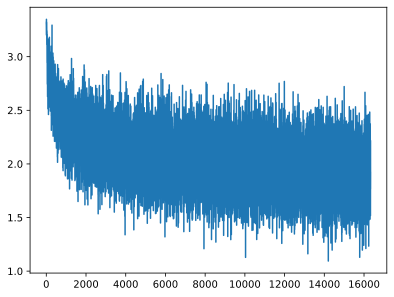

In [462]:
plt.plot(history)

## Appendix: Simple RNN in PyTorch

In [368]:
rnn = nn.RNN(d, h, batch_first=True)
x = torch.randn(B, T, d)
outs, state = rnn(x)
assert outs.shape == (B, T, h)
assert state.shape == (1, B, h)
assert torch.abs(outs[:, -1, :] - state).max() < 1e-8